In [1]:
from tqdm import tqdm 
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import Models
import ResNet50_Model

In [4]:
import CheXpertDataset
CheXpertDataset = importlib.reload(CheXpertDataset)

In [2]:
# Import the model
import importlib
Models = importlib.reload(Models)
ResNet50_Model = importlib.reload(ResNet50_Model)


In [3]:
from Dataset2 import dataset
DATA_DIR = '../vinbigdata-chestXRay/'
boxes_dir = DATA_DIR+'converted_data.csv'
images_dir = DATA_DIR+'converted'

In [4]:
# VinBigData Dataset
train_dataset, valid_dataset, test_dataset = dataset(7, images_dir, boxes_dir, no_finding=True)
train_dataset[0][1].shape

The number of training images: 11836
The number of validation images: 1480
The number of the test images: 1480


(7,)

In [5]:
# #from WholeDataset import train_dataset, valid_dataset, test_dataset
# from WholeDataset import dataset_whole
# train_dataset, valid_dataset, test_dataset = dataset_whole(images_dir, boxes_dir, 15)

In [6]:
class SaveBestModel:
    '''
    Class to save the best model while training. if the current validation loss
    is less than the previous least less, the save the model state'''
    
    def __init__(self, best_valid_loss=float('inf')):
        self.best_valid_loss = best_valid_loss
        
    def __call__(self, current_valid_loss, epoch, model, optimizer, criterion):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving the best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
            }, '../outputs/best_model_efficient.pth')
        

In [7]:
def calculate_pos_weights(labels):
    num_positives = labels.sum(axis=0)
    num_negatives = len(labels) - num_positives
    pos_weights = num_negatives/num_positives
    return torch.Tensor(pos_weights)

In [8]:
# train function
def train(model, trainloader, optimizer, criterion, device):
    print('Training')
    model.train()
    counter=0
    train_running_loss = 0.0
    for i, (image, label, index) in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter+=1
        image = image.to(device)
        label = label.to(device)
        label = label.to(torch.float32)
        optimizer.zero_grad()
        
        # forward pass
        output = model(image)
        # Calculate the loss
        loss = criterion(output, label)
        train_running_loss += loss.item()
               
        # Backward
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/counter
    
    return train_loss

In [9]:
# validation function
def validate(model, validloader, criterion, device):
    print('Validating')
    model.eval()
    counter=0
    val_running_loss = 0.0
    val_running_correct = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for i, (image, label, index) in tqdm(enumerate(validloader), total=len(validloader)):
            counter+=1
            image = image.to(device)
            label = label.to(device)
            label = label.to(torch.float32)
            # Forward pass
            outputs = model(image)
            
            # Calculate the loss
            loss = criterion(outputs, label)
            val_running_loss += loss.item()
            
            # Convert predictions and labels to numpy arrays
            predictions = torch.sigmoid(outputs).cpu().numpy()
            labels = label.cpu().numpy()
            
            # Round predictions to obtain binary values
            predictions = np.round(predictions)
            
            # Flatten predictions and labels
            predictions = predictions.flatten()
            labels = labels.flatten()
            
            # Append the predictions and labels to the lists
            y_pred.extend(predictions)
            y_true.extend(labels)
            
        # Calculate f1 score
        f1 = f1_score(y_true, y_pred, average='micro')
                    
        # Statistics
        val_loss = val_running_loss/counter
     
        return val_loss, f1

In [10]:
# Initialize the model and Training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# initialize the model
model = Models.model(model_type='efficient', pretrained=True, requires_grad=True, res = 'None', num_classes=7).to(device)
# learning parameters
lr = 0.01
epochs=20
batch_size=32

optimizer = optim.SGD(model.parameters(), lr, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr)

'''VinBigData Dataset'''
pos_weights = calculate_pos_weights(train_dataset.labels)
#print(pos_weights)
criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weights.to(device)).to(device) # VinBigData Dataset
#criterion = nn.BCEWithLogitsLoss()

#Initialize SaveBestModel class
save_best_model = SaveBestModel()

#scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


scheduler = lr_scheduler.LinearLR(optimizer, 
                                  start_factor = 1.0, # the number we multiply lr in the first epoch
                                  end_factor=0.3,
                                  total_iters=20) # the number of iterations that multicative factor reaches to 1


C:\Users\Theodora\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Theodora\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
'''Stanford CheXert Dataset'''

path = os.getcwd()
data_dir = os.path.join(os.path.dirname(path), 'data', 'stanford', 'CheXpert')
print(path)
print(data_dir)

image_shape = (224,224)
idx = ['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis', 'Pleural Effusion']
#idx = [7,10,11,13,15]
policy='diff'
dataset_dir = os.path.join(data_dir, "CheXpert-v1.0-small")
#print(dataset_dir)
dataset = CheXpertDataset.CheXpert(dataset_dir, idx, policy, image_shape)
train_dataset, valid_dataset, test_dataset = dataset.get_datasets()
trainloader, validloader, testloader = dataset.get_data_loaders(batch_size)

C:\Users\Theodora\Documents\master2\papers for diploma\Explainability\MSc_Thesis\src
C:\Users\Theodora\Documents\master2\papers for diploma\Explainability\MSc_Thesis\data\stanford\CheXpert


In [11]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(11836, 1480, 1480)

In [12]:
# This is for VinBigData Dataset
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


In [13]:
for image, label, index in trainloader:
    print('Image dimensions:', image.shape)
    print('labels dimensions:', label.shape)
    #print(index)
    print('Idx:', {index})
    break

Image dimensions: torch.Size([32, 3, 224, 224])
labels dimensions: torch.Size([32, 7])
Idx: {tensor([ 2600,  4409,  3092,   915,  7725, 11646,  7234,  5393,  6062,  6971,
         4343,  9681,  7349,  9920, 10855,  4057,  3418,  1432,  4345,  2875,
         2272,  3668,  3774,  9158,  3421,  4362,  3084,  3871,  9516,  6234,
         5208,  1004])}


In [14]:
from sklearn.metrics import precision_score,f1_score
torch.cuda.empty_cache()
# Start the training and validation
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
f1_valid = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(model, trainloader, optimizer, criterion, device)
    valid_epoch_loss, f1_epoch_valid = validate(model, validloader, criterion, device)
    
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    f1_valid.append(f1_epoch_valid)
    #train_acc.append(train_epoch_acc)
    #valid_acc.append(valid_epoch_acc)

    
    print(f"Train Loss: {train_epoch_loss:.3f}")
    print(f"Valid Loss: {valid_epoch_loss:.4f}")
    print(f"F1 score: {f1_epoch_valid:.4f}")
    
    # Save the best model till now if we have the least loss in the current epoch
    save_best_model(valid_epoch_loss, epoch, model, optimizer, criterion)
    print('='*50)
    
    before_lr = optimizer.param_groups[0]['lr']
    scheduler.step()
    after_lr = optimizer.param_groups[0]['lr']
    print('Epoch %d: SGD lr %.4f -> %.4f' % (epoch+1, before_lr, after_lr))
    
# # save the trained model weights for a final time
# save_model(epochs, model, optimizer, criterion)
    

Epoch 1 of 20
Training


100%|██████████| 370/370 [05:30<00:00,  1.12it/s]


Validating


100%|██████████| 47/47 [00:20<00:00,  2.29it/s]


Train Loss: 0.713
Valid Loss: 0.5678
F1 score: 0.8176

Best validation loss: 0.567795918342915

Saving the best model for epoch: 1

Epoch 1: SGD lr 0.0100 -> 0.0097
Epoch 2 of 20
Training


100%|██████████| 370/370 [02:38<00:00,  2.33it/s]


Validating


100%|██████████| 47/47 [00:12<00:00,  3.86it/s]


Train Loss: 0.533
Valid Loss: 0.4403
F1 score: 0.8639

Best validation loss: 0.4402706499429459

Saving the best model for epoch: 2

Epoch 2: SGD lr 0.0097 -> 0.0093
Epoch 3 of 20
Training


100%|██████████| 370/370 [01:36<00:00,  3.85it/s]


Validating


100%|██████████| 47/47 [00:12<00:00,  3.87it/s]


Train Loss: 0.486
Valid Loss: 0.4328
F1 score: 0.8529

Best validation loss: 0.43280118481909974

Saving the best model for epoch: 3

Epoch 3: SGD lr 0.0093 -> 0.0090
Epoch 4 of 20
Training


100%|██████████| 370/370 [01:38<00:00,  3.76it/s]


Validating


100%|██████████| 47/47 [00:13<00:00,  3.61it/s]


Train Loss: 0.443
Valid Loss: 0.4089
F1 score: 0.8567

Best validation loss: 0.4089064445901424

Saving the best model for epoch: 4

Epoch 4: SGD lr 0.0090 -> 0.0086
Epoch 5 of 20
Training


100%|██████████| 370/370 [01:39<00:00,  3.72it/s]


Validating


100%|██████████| 47/47 [00:11<00:00,  4.13it/s]


Train Loss: 0.421
Valid Loss: 0.4324
F1 score: 0.8390
Epoch 5: SGD lr 0.0086 -> 0.0083
Epoch 6 of 20
Training


100%|██████████| 370/370 [01:44<00:00,  3.53it/s]


Validating


100%|██████████| 47/47 [00:11<00:00,  4.11it/s]


Train Loss: 0.401
Valid Loss: 0.4110
F1 score: 0.8862
Epoch 6: SGD lr 0.0083 -> 0.0079
Epoch 7 of 20
Training


100%|██████████| 370/370 [01:40<00:00,  3.68it/s]


Validating


100%|██████████| 47/47 [00:12<00:00,  3.68it/s]


Train Loss: 0.383
Valid Loss: 0.3930
F1 score: 0.8998

Best validation loss: 0.39303818757229664

Saving the best model for epoch: 7

Epoch 7: SGD lr 0.0079 -> 0.0076
Epoch 8 of 20
Training


100%|██████████| 370/370 [01:51<00:00,  3.33it/s]


Validating


100%|██████████| 47/47 [00:12<00:00,  3.66it/s]


Train Loss: 0.376
Valid Loss: 0.4265
F1 score: 0.9046
Epoch 8: SGD lr 0.0076 -> 0.0072
Epoch 9 of 20
Training


100%|██████████| 370/370 [01:49<00:00,  3.37it/s]


Validating


100%|██████████| 47/47 [00:11<00:00,  3.96it/s]


Train Loss: 0.366
Valid Loss: 0.4342
F1 score: 0.9045
Epoch 9: SGD lr 0.0072 -> 0.0068
Epoch 10 of 20
Training


100%|██████████| 370/370 [01:45<00:00,  3.49it/s]


Validating


100%|██████████| 47/47 [00:12<00:00,  3.70it/s]


Train Loss: 0.349
Valid Loss: 0.4044
F1 score: 0.8921
Epoch 10: SGD lr 0.0068 -> 0.0065
Epoch 11 of 20
Training


100%|██████████| 370/370 [01:50<00:00,  3.35it/s]


Validating


100%|██████████| 47/47 [00:12<00:00,  3.65it/s]


Train Loss: 0.338
Valid Loss: 0.3990
F1 score: 0.8979
Epoch 11: SGD lr 0.0065 -> 0.0061
Epoch 12 of 20
Training


100%|██████████| 370/370 [01:48<00:00,  3.41it/s]


Validating


100%|██████████| 47/47 [00:12<00:00,  3.67it/s]


Train Loss: 0.324
Valid Loss: 0.4243
F1 score: 0.9036
Epoch 12: SGD lr 0.0061 -> 0.0058
Epoch 13 of 20
Training


100%|██████████| 370/370 [01:49<00:00,  3.38it/s]


Validating


100%|██████████| 47/47 [00:12<00:00,  3.70it/s]


Train Loss: 0.318
Valid Loss: 0.4258
F1 score: 0.9064
Epoch 13: SGD lr 0.0058 -> 0.0054
Epoch 14 of 20
Training


100%|██████████| 370/370 [01:50<00:00,  3.36it/s]


Validating


100%|██████████| 47/47 [00:13<00:00,  3.57it/s]


Train Loss: 0.308
Valid Loss: 0.4357
F1 score: 0.9061
Epoch 14: SGD lr 0.0054 -> 0.0051
Epoch 15 of 20
Training


100%|██████████| 370/370 [01:49<00:00,  3.36it/s]


Validating


100%|██████████| 47/47 [00:13<00:00,  3.60it/s]


Train Loss: 0.295
Valid Loss: 0.4129
F1 score: 0.9081
Epoch 15: SGD lr 0.0051 -> 0.0047
Epoch 16 of 20
Training


100%|██████████| 370/370 [01:48<00:00,  3.40it/s]


Validating


100%|██████████| 47/47 [00:12<00:00,  3.63it/s]


Train Loss: 0.288
Valid Loss: 0.4280
F1 score: 0.9157
Epoch 16: SGD lr 0.0047 -> 0.0044
Epoch 17 of 20
Training


100%|██████████| 370/370 [01:49<00:00,  3.39it/s]


Validating


100%|██████████| 47/47 [00:12<00:00,  3.62it/s]


Train Loss: 0.278
Valid Loss: 0.4171
F1 score: 0.8986
Epoch 17: SGD lr 0.0044 -> 0.0040
Epoch 18 of 20
Training


100%|██████████| 370/370 [01:48<00:00,  3.41it/s]


Validating


100%|██████████| 47/47 [00:12<00:00,  3.69it/s]


Train Loss: 0.271
Valid Loss: 0.4358
F1 score: 0.9125
Epoch 18: SGD lr 0.0040 -> 0.0037
Epoch 19 of 20
Training


100%|██████████| 370/370 [01:48<00:00,  3.41it/s]


Validating


100%|██████████| 47/47 [00:12<00:00,  3.62it/s]


Train Loss: 0.267
Valid Loss: 0.4309
F1 score: 0.9127
Epoch 19: SGD lr 0.0037 -> 0.0034
Epoch 20 of 20
Training


100%|██████████| 370/370 [01:49<00:00,  3.37it/s]


Validating


100%|██████████| 47/47 [00:12<00:00,  3.74it/s]

Train Loss: 0.261
Valid Loss: 0.4758
F1 score: 0.9141
Epoch 20: SGD lr 0.0034 -> 0.0030


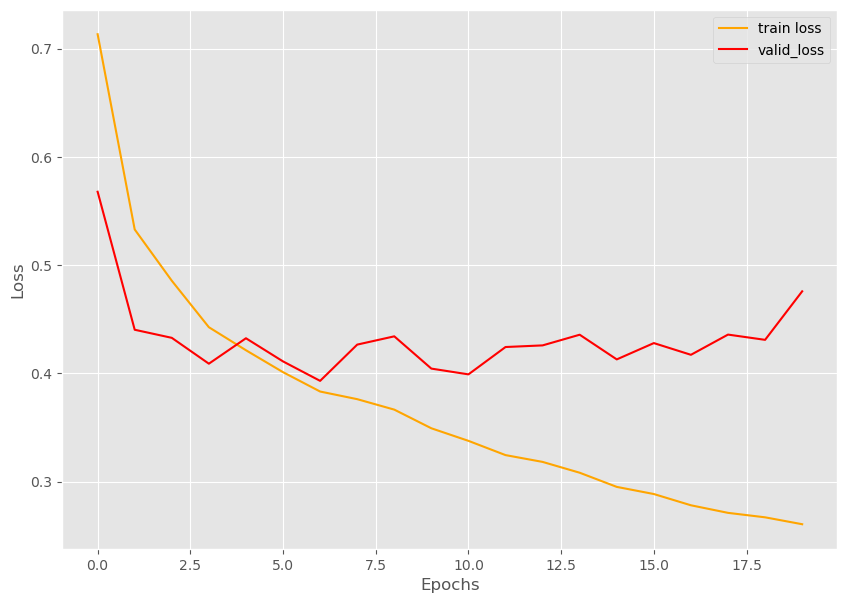

In [15]:
# Loss plots
plt.figure(figsize=(10,7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(valid_loss, color='red', label='valid_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../outputs/loss_efficient_7c.png')

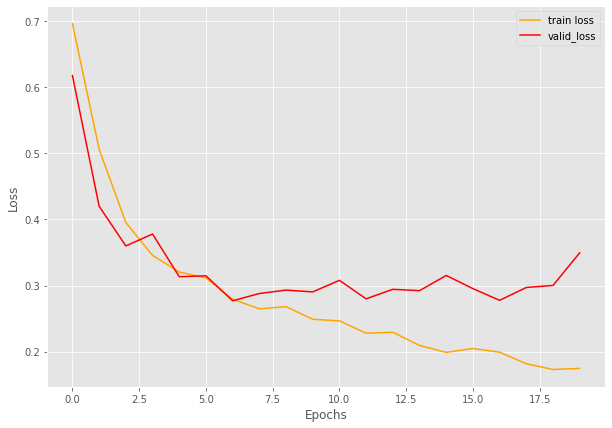

In [16]:
# # Save the trained model to disk
# torch.save({
#     'epoch': epochs,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'loss': criterion,
#     }, '../outputs/model_50np.pth')

# plot and save the train and validation line graphs
# Loss plots
plt.figure(figsize=(10,7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(valid_loss, color='red', label='valid_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../outputs/loss_np50_3c_pos.png')

# # # Accuracy plots
# # plt.figure(figsize=(10,7))
# # plt.plot(train_acc, color='orange', label='train acc')
# # plt.plot(valid_acc, color='red', label='valid_acc')
# # plt.xlabel('Epochs')
# # plt.ylabel('F1 Score')
# # plt.legend()
# # plt.savefig('../outputs/acc_np18.png')

plt.show()